In [2]:
import os
os.environ['XRT_TPU_CONFIG']
#='tpu_worker;0;10.77.227.146:8470'

'tpu_worker;0;10.77.227.146:8470'

In [3]:
%matplotlib inline
RESULT_IMG_PATH = '/tmp/test_result.png'
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from IPython import display 

    
def plot_results(images):
    #display.clear_output()
    num_images = images.shape[0]
    fig, axes = plt.subplots(4, 6, figsize=(11, 9))

    for i, ax in enumerate(fig.axes):
        ax.axis('off')
        if i >= num_images:
          continue
        img = images[i]
        img = img.squeeze() # [1,Y,X] -> [Y,X]
        ax.imshow(img)
    plt.savefig(RESULT_IMG_PATH, transparent=True)
    #display(RESULT_IMG_PATH)

In [4]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.optim import Adam
import torch.nn.functional as F

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu



In [5]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 0.001
FLAGS['momentum'] = 0.5
FLAGS['num_epochs'] = 15
FLAGS['num_cores'] = 8
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [6]:
def mnist_data():
    compose = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
    out_dir = '{}/dataset'.format(FLAGS['datadir'])
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [7]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024,1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024)
        x = self.out(x)
        return x

In [8]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 256*7*7)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=64, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64, out_channels=32, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=32, out_channels=1, kernel_size=3,
                stride=1, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 256, 7, 7)

        # Convolutional layers
        x = self.conv1(x)

        x = self.conv2(x)

        x = self.conv3(x)

        x = self.conv4(x)

        # Apply Tanh
        return self.out(x)

    


In [9]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [10]:
def real_data_target(size, device):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def fake_data_target(size, device):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [11]:
# Noise
def noise(size, device):
    n = Variable(torch.randn(size, 100))
    return n.to(device)

In [28]:
def train_gan(rank):
    torch.manual_seed(1)
    
    if not xm.is_master_ordinal():
        # Barrier: Wait until master is done downloading
        xm.rendezvous('download_only_once')
    # Dataset
    data = mnist_data()
    if xm.is_master_ordinal():
        # Master is done, other workers can proceed now
        xm.rendezvous('download_only_once')
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        data,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True)
    

    # Create loader with data, so that we can iterate over it
    #train_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
    train_loader = torch.utils.data.DataLoader(
      data,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

    # Num batches
    num_batches = len(train_loader)
    
    device = xm.xla_device()
    
    generator = GenerativeNet().to(device)
    generator.apply(init_weights)

    discriminator = DiscriminativeNet().to(device)
    discriminator.apply(init_weights)
    
    # Optimizers
    d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_optimizer = Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))

    # Number of epochs
    num_epochs = FLAGS['num_epochs'] 
    # Loss function
    loss = nn.BCELoss()
    
    num_test_samples = 24
    test_noise = noise(num_test_samples, device)
    
    def train_step_discriminator(optimizer, real_data, fake_data, device):
        # Reset gradients
        optimizer.zero_grad()

        # 1. Train on Real Data
        prediction_real = discriminator(real_data)
        # Calculate error and backpropagate
        error_real = loss(prediction_real, real_data_target(real_data.size(0), device))
        

        # 2. Train on Fake Data
        prediction_fake = discriminator(fake_data)
        # Calculate error and backpropagate

        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0), device))
        total_error = error_real + error_fake
        total_error.backward()

        # Update weights with gradients
        xm.optimizer_step(optimizer)

        return total_error, prediction_real, prediction_fake
        #return (0, 0, 0)

    def train_step_generator(optimizer, fake_data, device):
        # Reset gradients
        optimizer.zero_grad()
        # Sample noise and generate fake data
        prediction = discriminator(fake_data)
        # Calculate error and backpropagate
        error = loss(prediction, real_data_target(prediction.size(0), device))
        error.backward()
        # Update weights with gradients
        xm.optimizer_step(optimizer)

        # Return error
        return error


    def train_loop_fn(loader):
        tracker = xm.RateTracker()
        for n_batch, (real_batch,_) in enumerate(loader):
            # Train Step Descriminator
            real_data = Variable(real_batch).to(device)
            fake_data = generator(noise(real_data.size(0), device)).detach()
            d_error, d_pred_real, d_pred_fake = train_step_discriminator(d_optimizer,
                                                                real_data, fake_data, device)
            #Train Step Generator
            fake_data = generator(noise(real_batch.size(0), device))
            g_error = train_step_generator(g_optimizer, fake_data, device)
            #print(f'D_ERROR: {d_error.item()}, G_ERROR: {g_error.item()}')
        return d_error.item(), g_error.item()


            # Display Test Images
            # Save Model Checkpoints

    for epoch in range(1, FLAGS['num_epochs'] +1):
        para_loader = pl.ParallelLoader(train_loader, [device])
        d_error, g_error = train_loop_fn (para_loader.per_device_loader(device))
        xm.master_print("Finished training epoch {}: D_error:{}, G_error: {}".format(epoch, d_error, g_error))
        if rank == 0 and epoch %5 == 0:
            # Retrieve tensors that are on TPU core 0 and plot.
            plot_results(generator(test_noise).detach().cpu())
    #return generator

# Start training processes
def _mp_fn(rank, flags):
    global FLAGS
    FLAGS = flags
    torch.set_default_tensor_type('torch.FloatTensor')
    train_gan(rank)
    #if rank == 0:
      # Retrieve tensors that are on TPU core 0 and plot.
      # plot_results(images.cpu())

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')



Finished training epoch 1: D_error:1.3716411590576172, G_error: 0.7077291011810303
Finished training epoch 2: D_error:1.3518131971359253, G_error: 0.725326657295227
Finished training epoch 3: D_error:1.3123414516448975, G_error: 0.7402970790863037
Finished training epoch 4: D_error:1.2861442565917969, G_error: 0.802460253238678
Finished training epoch 5: D_error:1.2375190258026123, G_error: 0.8021090030670166
Finished training epoch 6: D_error:1.2001140117645264, G_error: 0.8503595590591431
Finished training epoch 7: D_error:1.1854474544525146, G_error: 0.9181938767433167
Finished training epoch 8: D_error:1.1336438655853271, G_error: 0.9237279891967773
Finished training epoch 9: D_error:1.0416805744171143, G_error: 0.9245396852493286
Finished training epoch 10: D_error:1.0859274864196777, G_error: 0.9458535313606262
Finished training epoch 11: D_error:1.0291880369186401, G_error: 1.0037106275558472
Finished training epoch 12: D_error:1.0439339876174927, G_error: 0.94843590259552
Finis

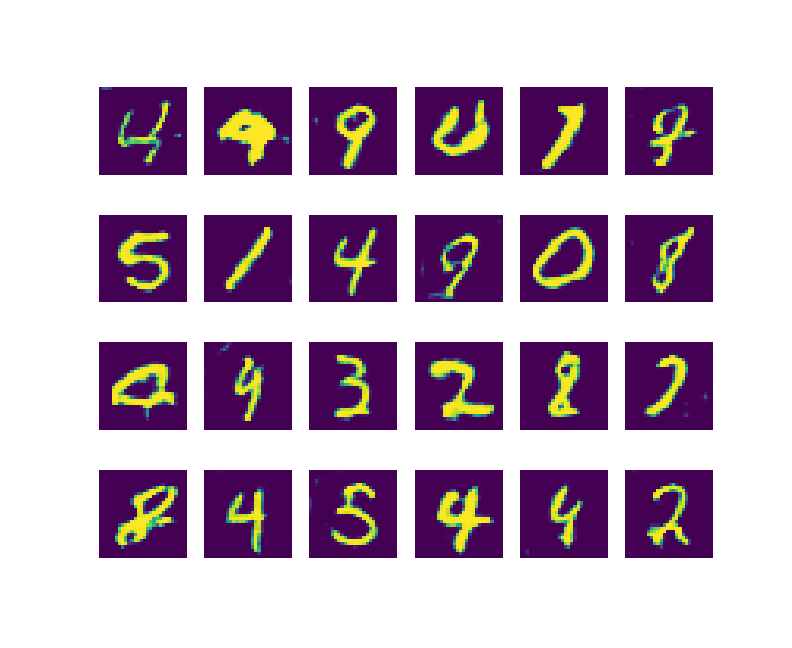

In [29]:
from IPython.display import Image
Image(filename=RESULT_IMG_PATH)